## Lista 3 - KNN e Árvores de decisão
Professor César Lincoln C. Mattos, 
Aprendizagem de Máquina - 2023.1,

José Renato S. Freitas

In [141]:
import numpy as np
from numpy import array
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from scipy.stats import multivariate_normal
from scipy.spatial import distance
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")

In [142]:
escalar_minmax = MinMaxScaler()
K = 10

## Questão 1

In [143]:
dataset = np.genfromtxt("./kc2.csv", delimiter=',', skip_header=1)
X = dataset[:, :-1]
y = dataset[:, -1]
print(f'x: {X.shape}, y: {y.shape}')

x: (213, 21), y: (213,)


### KNN

In [144]:
# funções Euclidianas
def obtem_distancia_euclidiana(X, x_teste):
    "Retorna um vetor de distâncias"
    diferenca_ao_quadrado = (X - x_teste) ** 2 
    distancia = np.sum(diferenca_ao_quadrado, axis=1) ** .5 
    return distancia

def obtem_k_vizinhos_mais_proximos(X, x_teste, k):
    "Retorna k-vizinhos ordenados pela menor distância"
    distancias = obtem_distancia_euclidiana(X, x_teste)
    indices_ordenados = np.argsort(distancias)
    qtde_vizinhos = k + 1
    return indices_ordenados[1:qtde_vizinhos]

def classificacao_knn_euclidiana(X, y, x_teste, k):
    indices_ordenados = obtem_k_vizinhos_mais_proximos(X, x_teste, k)
    y_ordenado = y[indices_ordenados]
    conta_classes = np.unique(y_ordenado, return_counts=True)
    indice_maximo = np.argmax(conta_classes[1])
    predicao = conta_classes[0][indice_maximo]
    return predicao

# funções Mahalanobis
def obtem_distancia_mahalanobis(xi, x, cov):
  distancias = []
  inversa_matriz_covariancia = np.linalg.inv(cov)
  x_menos_xi = x - xi
  distancias = (x_menos_xi.T @ inversa_matriz_covariancia @ x_menos_xi)**.5
  return distancias

def obtem_vizinhos_mais_proximos_maha(X, x_teste, k):
    cov = np.cov(X.T)
    dist = [obtem_distancia_mahalanobis(xi, x_teste, cov) for xi in X]
    indices_ordenacao = np.argsort(dist)
    qtde_vizinhos = k + 1
    k_vizinhos = indices_ordenacao[1:qtde_vizinhos]
    return k_vizinhos

def classificacao_knn_mahalanobis(X, y, x_teste, k):
    indices_ordenacao = obtem_vizinhos_mais_proximos_maha(X, x_teste, k)
    y_ordenado = y[indices_ordenacao]
    conta_classes = np.unique(y_ordenado, return_counts=True)
    indice_maximo = np.argmax(conta_classes[1])
    predicao = conta_classes[0][indice_maximo]
    return predicao

[5.560858000395308, 4.683789955626929, 5.439695676364172, 4.069495307896643, 4.29477029026332, 5.879492662279377, 5.277351182869694, 8.61145809074628, 6.959162355025932, 4.739327175536375, 5.840264134867544, 4.8154991448041775, 5.566702365441974, 6.174562305878986, 4.20087325853581, 5.840264134867544, 5.840264134867544, 4.79297626666026, 4.124672681085407, 6.376179283628339, 4.946950799229718, 5.879492662279377, 5.060917542324835, 5.840264134867544, 4.246700908246319, 1.616559571319766, 5.491592773420702, 6.31085701025741, 5.840264134867544, 5.192000513242237, 5.017840105575986, 4.753858505809629, 0.8202532590259357, 5.192000513242237, 5.840264134867544, 6.93972959393879, 5.078807863197937, 5.879492662279377, 5.840264134867544, 12.033960322469563, 4.9790701787109235, 8.812857966163698, 5.840264134867544, 3.50495562869802, 5.61922754712311, 8.282663292821507, 5.3474804612823705, 5.840264134867544, 5.840264134867544, 5.500841089691451, 6.4534365159139355, 5.153275713403996, 0.82025325902

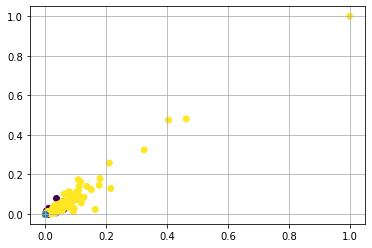

In [6]:
import numpy as np
from scipy.spatial.distance import mahalanobis

__X = escalar_minmax.fit_transform(X)
ponto_novo = np.random.rand(1, __X.shape[1])
ponto_novo = escalar_minmax.fit_transform(ponto_novo)
matriz_covariancia = np.cov(__X.T)

# comparando a função obtem_distancia_mahalanobis() com a mahalanobis() da lib scipy
mahalanobis_dist = [mahalanobis(x, ponto_novo[0], np.linalg.inv(matriz_covariancia)) for x in __X]
print(mahalanobis_dist)

my_mahalanobis_dist = [obtem_distancia_mahalanobis(xi, ponto_novo[0], matriz_covariancia) for xi in __X]
print(my_mahalanobis_dist)

plt.scatter(__X[:, 0], __X[:, 1], c=y)
plt.scatter(ponto_novo[0][0], ponto_novo[0][0])
plt.grid()

## Árvore de Decisão

In [145]:
# funções
def gini(y):
    """Índice ou impureza de Gini"""
    if y.shape[0] == 0: return 0.0
    classes, cont_classes = np.unique(y, return_counts=True)
    prob_ck = cont_classes / y.shape[0]
    G = 1.0 - np.sum(prob_ck**2)
    return G

def gini_medio_das_ramificacoes(gini_menor, gini_maior_igual, qtde_gini_menor):
    probabilidade = qtde_gini_menor/y.shape[0]
    gini_medio = (probabilidade*gini_menor) + ((1 - probabilidade)*gini_maior_igual)
    return gini_medio
    
def classe_mais_frequente(y):
    classes, cont_classes = np.unique(y, return_counts=True)
    return classes[np.argmax(cont_classes)]

In [146]:
class No():
    def __init__(self, pai=None):
        self.pai = pai
        self.filho_esquerdo = None   
        self.filho_direito = None 
        self.indice_da_feature = None
        self.valor_limiar = None
        self.eh_folha = True
        self.saida = None
        
class ArvoreDeDecisao():
    def __init__(self, criterio=gini, max_depth=None):
        self.criterio = criterio
        self.profundidade_maxima = np.inf if max_depth is None else max_depth
        self.raiz = No()

    def treinamento(self, x, y):
        self.__construir_a_arvore(self.raiz, x, y)


    def __construir_a_arvore(self, no_pai, x, y, profundidade=0):
        no_pai.indice_da_feature, no_pai.valor_limiar, melhor_ganho = self.__encontra_melhor_corte(x, y)

        if melhor_ganho == 0.0 or profundidade > self.profundidade_maxima: 
            no_pai.saida = classe_mais_frequente(y)
            return

        filho_esquerdo = No(pai=no_pai)
        filho_direito = No(pai=no_pai)
        no_pai.eh_folha = False

        x_esquerdo, y_esquerdo, x_direito, y_direito = self.__dividir_dados_pelo_valor_da_feature(x, y, no_pai.indice_da_feature, no_pai.valor_limiar)

        if len(x_esquerdo) >= 2:
            self.__construir_a_arvore(filho_esquerdo, x_esquerdo, y_esquerdo, profundidade + 1)
        else:
            filho_esquerdo.saida = classe_mais_frequente(y_esquerdo)

        if len(x_direito) >= 2:
            self.__construir_a_arvore(filho_direito, x_direito, y_direito, profundidade + 1)
        else:
            filho_direito.saida = classe_mais_frequente(y_direito)

        no_pai.filho_esquerdo = filho_esquerdo
        no_pai.filho_direito = filho_direito


    def __encontra_melhor_corte(self, x, y):
        melhor_ganho, melhor_atributo, melhor_valor = 0.0, None, None
        impureza_atual = self.criterio(y) # o critério é a função gini

        for indice_da_feature in range(x.shape[1]):
            valores_da_feature = np.unique(x[:, indice_da_feature])
            
            for valor in valores_da_feature:
                _, y_left, _, y_right = self.__dividir_dados_pelo_valor_da_feature(x, y, indice_da_feature, valor)
                
                impureza_gini_menor = self.criterio(y_left)
                impureza_gini_maior_igual = self.criterio(y_right)

                ganho = impureza_atual - gini_medio_das_ramificacoes(impureza_gini_menor, impureza_gini_maior_igual, len(y_left))
                if ganho > melhor_ganho:
                    melhor_ganho = ganho
                    melhor_atributo = indice_da_feature
                    melhor_valor = valor

        return melhor_atributo, melhor_valor, melhor_ganho
    
    def __dividir_dados_pelo_valor_da_feature(self, x, y, indice_atributo, valor):
        indices_cujo_valor_e_menor = x[:, indice_atributo] < valor
        indices_cujo_valor_e_maior_ou_igual = np.invert(indices_cujo_valor_e_menor)
        return x[indices_cujo_valor_e_menor], y[indices_cujo_valor_e_menor], x[indices_cujo_valor_e_maior_ou_igual], y[indices_cujo_valor_e_maior_ou_igual]
    
    def predicao(self, x):
        return np.array([self.__computar_saida(xi, self.raiz) for xi in x])
    
    def __computar_saida(self, xi, node):
        if node.eh_folha: return node.saida
        
        descer_a_direita = xi[node.indice_da_feature] >= node.valor_limiar
        return self.__computar_saida(xi, node.filho_direito if descer_a_direita else node.filho_esquerdo)

### K-fold

In [114]:
kfold = KFold(n_splits=K, random_state=42, shuffle=True)
fold = 0
accuracias = [[], [], [], []]
revocacoes = [[], [], [], []]
f1s = [[], [], [], []]
precisoes = [[], [], [], []]
metricas_arvore_decisao = [[],[],[],[]]

for train_index, test_index in kfold.split(X):
  fold += 1
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

  X_train = escalar_minmax.fit_transform(X_train)
  X_test = escalar_minmax.fit_transform(X_test)

  y_predito = [classificacao_knn_euclidiana(X_train, y_train, x, 1) for x in X_test]
  y_predito_k5 = [classificacao_knn_euclidiana(X_train, y_train, x, 5) for x in X_test]
  y_predito_maha = [classificacao_knn_mahalanobis(X_train, y_train, x, 1) for x in X_test]
  y_predito_maha_k5 = [classificacao_knn_mahalanobis(X_train, y_train, x, 5) for x in X_test]

  accuracias[0].append(accuracy_score(y_test, y_predito))
  accuracias[1].append(accuracy_score(y_test, y_predito_k5))
  accuracias[2].append(accuracy_score(y_test, y_predito_maha))
  accuracias[3].append(accuracy_score(y_test, y_predito_maha_k5))

  revocacoes[0].append(recall_score(y_test, y_predito))
  revocacoes[1].append(recall_score(y_test, y_predito_k5))
  revocacoes[2].append(recall_score(y_test, y_predito_maha))
  revocacoes[3].append(recall_score(y_test, y_predito_maha_k5))

  f1s[0].append(f1_score(y_test, y_predito))
  f1s[1].append(f1_score(y_test, y_predito_k5))
  f1s[2].append(f1_score(y_test, y_predito_maha))
  f1s[3].append(f1_score(y_test, y_predito_maha_k5))

  precisoes[0].append(precision_score(y_test, y_predito))
  precisoes[1].append(precision_score(y_test, y_predito_k5))
  precisoes[2].append(precision_score(y_test, y_predito_maha))
  precisoes[3].append(precision_score(y_test, y_predito_maha_k5))

  ad = ArvoreDeDecisao()
  ad.treinamento(X_train, y_train)
  y_predito_ad = ad.predicao(X_test)

  metricas_arvore_decisao[0].append(accuracy_score(y_test, y_predito_ad))
  metricas_arvore_decisao[1].append(recall_score(y_test, y_predito_ad))
  metricas_arvore_decisao[2].append(f1_score(y_test, y_predito_ad))
  metricas_arvore_decisao[3].append(precision_score(y_test, y_predito_ad))

AD 0.6818181818181818
AD 0.7272727272727273
AD 0.7727272727272727
AD 0.7142857142857143
AD 0.5714285714285714
AD 0.7142857142857143
AD 0.6666666666666666
AD 0.47619047619047616
AD 0.6666666666666666
AD 0.6190476190476191


### # Métricas do KNN

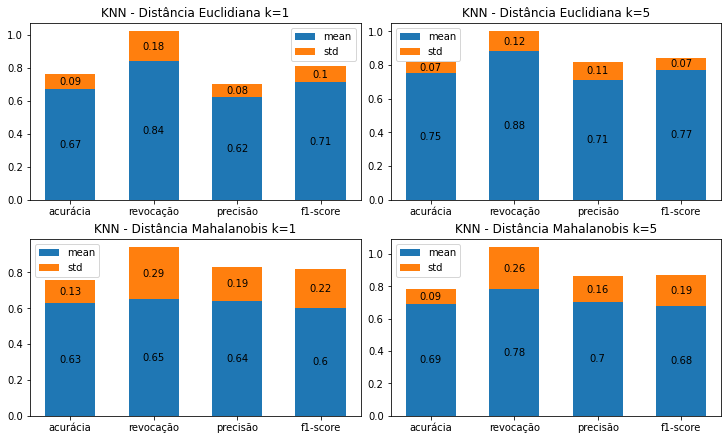

In [150]:
colunas = ('acurácia', 'revocação','precisão', 'f1-score')
metricas = {
    'mean': np.array([np.round(np.mean(accuracias[0]),2), np.round(np.mean(revocacoes[0]),2), np.round(np.mean(precisoes[0]),2), np.round(np.mean(f1s[0]),2)]),
    'std': np.array([np.round(np.std(accuracias[0]),2), np.round(np.std(revocacoes[0]),2), np.round(np.std(precisoes[0]),2), np.round(np.std(f1s[0]),2)])
}
metricas_k5 = {
    'mean': np.array([np.round(np.mean(accuracias[1]),2), np.round(np.mean(revocacoes[1]),2), np.round(np.mean(precisoes[1]),2), np.round(np.mean(f1s[1]),2)]),
    'std': np.array([np.round(np.std(accuracias[1]),2), np.round(np.std(revocacoes[1]),2), np.round(np.std(precisoes[1]),2), np.round(np.std(f1s[1]),2)])
}
metricas_maha = {
    'mean': np.array([np.round(np.mean(accuracias[2]),2), np.round(np.mean(revocacoes[2]),2), np.round(np.mean(precisoes[2]),2), np.round(np.mean(f1s[2]),2)]),
    'std': np.array([np.round(np.std(accuracias[2]),2), np.round(np.std(revocacoes[2]),2), np.round(np.std(precisoes[2]),2), np.round(np.std(f1s[2]),2)])
}
metricas_maha_k5 = {
    'mean': np.array([np.round(np.mean(accuracias[3]),2), np.round(np.mean(revocacoes[3]),2), np.round(np.mean(precisoes[3]),2), np.round(np.mean(f1s[3]),2)]),
    'std': np.array([np.round(np.std(accuracias[3]),2), np.round(np.std(revocacoes[3]),2), np.round(np.std(precisoes[3]),2), np.round(np.std(f1s[3]),2)])
}


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,6), layout='constrained')
bottom = np.zeros(4)
for metrica, qtde_metrica in metricas.items():
    p = ax1.bar(colunas, qtde_metrica, width=0.6, label=metrica, bottom=bottom)
    bottom += qtde_metrica
    ax1.bar_label(p, label_type='center')
    ax1.set_title('KNN - Distância Euclidiana k=1')
    ax1.legend()

bottom = np.zeros(4)
for metrica, qtde_metrica in metricas_k5.items():
    p = ax2.bar(colunas, qtde_metrica, width=0.6, label=metrica, bottom=bottom)
    bottom += qtde_metrica
    ax2.bar_label(p, label_type='center')
    ax2.set_title('KNN - Distância Euclidiana k=5')
    ax2.legend()

bottom = np.zeros(4)
for metrica, qtde_metrica in metricas_maha.items():
    p = ax3.bar(colunas, qtde_metrica, width=0.6, label=metrica, bottom=bottom)
    bottom += qtde_metrica
    ax3.bar_label(p, label_type='center')
    ax3.set_title('KNN - Distância Mahalanobis k=1')
    ax3.legend()    

bottom = np.zeros(4)
for metrica, qtde_metrica in metricas_maha_k5.items():
    p = ax4.bar(colunas, qtde_metrica, width=0.6, label=metrica, bottom=bottom)
    bottom += qtde_metrica
    ax4.bar_label(p, label_type='center')
    ax4.set_title('KNN - Distância Mahalanobis k=5')
    ax4.legend()  

### # Métricas da Árvore de Decisão

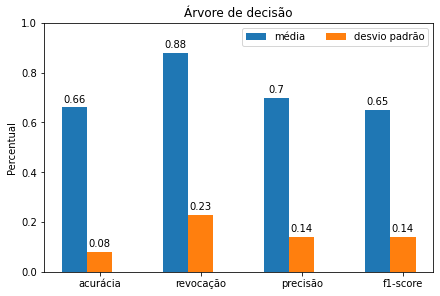

In [156]:
metricas_ad_agrupada = {
    'média': np.array([np.round(np.mean(metricas_arvore_decisao[0]),2), np.round(np.mean(metricas_arvore_decisao[1]),2), np.round(np.mean(metricas_arvore_decisao[2]),2), np.round(np.mean(metricas_arvore_decisao[3]),2)]),
    'desvio padrão': np.array([np.round(np.std(metricas_arvore_decisao[0]),2), np.round(np.std(metricas_arvore_decisao[1]),2), np.round(np.std(metricas_arvore_decisao[2]),2), np.round(np.std(metricas_arvore_decisao[3]),2)])
}
x = np.arange(len(colunas))  # posições das labels
largura_da_barra = 0.25  # largua das barras
multiplicador_para_exibir_a_barra = 0

fig, ax = plt.subplots(layout='constrained')

for metrica, medida in metricas_ad_agrupada.items():
    offset = largura_da_barra * multiplicador_para_exibir_a_barra
    a_barra = ax.bar(x + offset, medida, largura_da_barra, label=metrica)
    ax.bar_label(a_barra, padding=3)
    multiplicador_para_exibir_a_barra += 1

ax.set_ylabel('Percentual')
ax.set_title('Árvore de decisão')
ax.set_xticks(x + largura_da_barra, colunas)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 1)

plt.show()